# **Užduotis**

Duotas *train set'as*. Jis sudarytas iš paveikslėlių, kurių kiekviename pavaizduota figūra (apskritimas, trikampis, kvadratas, penkiakampis arba šešiakampis). Naudojantis *deep learning'u*, reikia sukurti modelį, kuris mokėtų suklasifikuoti paveikslėlius pagal tai, kiek paveikslėlyje esanti geometrinė figūra turi kampų. Kadangi turime paveikslėlius (X) ir kiekvienam paveikslėliui priskiriamą skaičių (y), tai užduotis yra *supervised learning classification* tipo.

## **Duomenų įkėlimas, paruošimas**

Iš pradžių importuojame reikalingus paketus.

In [3]:
#%matplotlib inline

#import os
#import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, \
                                    Activation, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam #SGD
from tensorflow.keras.callbacks import TensorBoard
#from IPython.display import YouTubeVideo
#from PIL import Image

Įkeliame duomenis (X ir y), kuriuos turime ir kuriais treniruosime modelį.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import pickle
import gzip

X,y = pickle.load(gzip.open('/content/drive/My Drive/Colab Notebooks/flatland_train.data', 'rb'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Išsiaiškiname, kokio pavidalo X duomenys.

In [5]:
X.shape

(10000, 50, 50)

Matome, kad mūsų duotame duomenų rinkinyje (*train set*) yra 10tūkst. 50x50 paveiksliukų.

Pasižiūrime, kaip atrodo dalis *train set'o*.

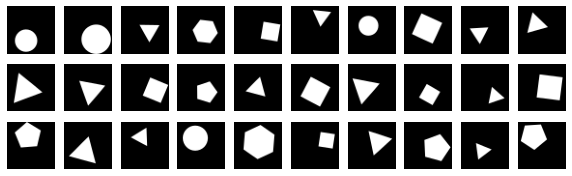

In [9]:
plt.figure(figsize=(10, 3))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')
plt.show()

Viena eilute y pakeičiame taip, kad tai būtų iš eilės einantys skaičiai - klasės nuo 0 iki 4, t.y. apskritimas - 0 klasė, trikampis - 1 klasė, kvadratas - 2 klasė, penkiakampis - 3 klasė, šešiakampis - 4 klasė. Taip pat X duomenis normalizuojame (padalijus iš 255, paveiksliuko pikselių reikšmės tampa lygios reikšmei tarp 0 ir 1, t.y. jie atsiranda vienoje skalėje) 

In [10]:
y[y!=0] -= 2
X = X/255

## **Modelio kūrimas**

### **DNN**

Pirmiausia bandysime sukurti paprastą neurotinklų modelį (DNN). 

Kol kas aišku tiek, kad:
- paskutinis sluoksnis turi turėti 5 neuronus, nes turime tik 5 skirtingas figūrų klases;
- input_shape=[50,50]

Kitus dalykus išsiaiškinsime atlikdami daug eksperimentų.

Taigi, iš pradžių kuriame modelį naudojant tik paprastą 3 sluoksnių neuronų tinklą. Naudojame relu aktyvaciją ir softmax (paskutiniam sluoksniui), optimizatorius - *stochastic gradient descent*. 

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[50, 50]))
model.add(keras.layers.Dense(1000, activation="relu"))
model.add(keras.layers.Dense(500, activation="relu"))
model.add(keras.layers.Dense(5, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              2501000   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2505      
Total params: 3,004,005
Trainable params: 3,004,005
Non-trainable params: 0
_________________________________________________________________


Treniruojame modelį.

In [12]:
model.fit(X, y, epochs=40, validation_split=0.2) 

Epoch 1/40
250/250 [==============================] - 5s 21ms/step - loss: 1.4526 - accuracy: 0.3862 - val_loss: 1.3789 - val_accuracy: 0.4350
Epoch 2/40
250/250 [==============================] - 5s 20ms/step - loss: 1.3089 - accuracy: 0.4506 - val_loss: 1.3107 - val_accuracy: 0.4570
Epoch 3/40
250/250 [==============================] - 5s 20ms/step - loss: 1.2360 - accuracy: 0.4820 - val_loss: 1.2582 - val_accuracy: 0.4755
Epoch 4/40
250/250 [==============================] - 5s 20ms/step - loss: 1.1733 - accuracy: 0.5149 - val_loss: 1.2350 - val_accuracy: 0.4480
Epoch 5/40
250/250 [==============================] - 5s 20ms/step - loss: 1.1105 - accuracy: 0.5426 - val_loss: 1.1658 - val_accuracy: 0.5010
Epoch 6/40
250/250 [==============================] - 5s 21ms/step - loss: 1.0511 - accuracy: 0.5757 - val_loss: 1.1055 - val_accuracy: 0.5235
Epoch 7/40
250/250 [==============================] - 5s 21ms/step - loss: 0.9949 - accuracy: 0.5941 - val_loss: 1.0682 - val_accuracy: 0.5450

Šis paprastas DNN modelis veikia labai prastai. Tikslumas mažas, *validation accuracy* daug skiriasi nuo *accuracy*, be to, *validation accuracy* "šokinėja", vadinasi, modelis *overfitina*, t.y. modelis, išmokęs pusėtinai atpažinti 80proc. *train set'o*, turi didelių problemų atpažįstant kitus 20proc. Be to, gana didelis epochų kiekis. Ieškome geresnių variantų, žiūrime, ką galime pakeisti, kad tikslumas būtų didesnis.

Didelių pakeitimų kol kas nedarome. Bandome padidinti neuronų skaičių sluoksniuose ir pakeičiame sgd optimizatorių į adam.

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[50, 50]))
model.add(keras.layers.Dense(1200, activation="relu"))
model.add(keras.layers.Dense(600, activation="relu"))
model.add(keras.layers.Dense(5, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1200)              3001200   
_________________________________________________________________
dense_4 (Dense)              (None, 600)               720600    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 3005      
Total params: 3,724,805
Trainable params: 3,724,805
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X, y, epochs=40, validation_split=0.2)

Epoch 1/40
250/250 [==============================] - 8s 31ms/step - loss: 1.3917 - accuracy: 0.4108 - val_loss: 1.1612 - val_accuracy: 0.4930
Epoch 2/40
250/250 [==============================] - 7s 30ms/step - loss: 1.0017 - accuracy: 0.5459 - val_loss: 0.9088 - val_accuracy: 0.5735
Epoch 3/40
250/250 [==============================] - 8s 31ms/step - loss: 0.7904 - accuracy: 0.6384 - val_loss: 0.8247 - val_accuracy: 0.6265
Epoch 4/40
250/250 [==============================] - 8s 31ms/step - loss: 0.6724 - accuracy: 0.6885 - val_loss: 0.7328 - val_accuracy: 0.6610
Epoch 5/40
250/250 [==============================] - 8s 30ms/step - loss: 0.5979 - accuracy: 0.7222 - val_loss: 0.7337 - val_accuracy: 0.6475
Epoch 6/40
250/250 [==============================] - 8s 31ms/step - loss: 0.5670 - accuracy: 0.7326 - val_loss: 0.7041 - val_accuracy: 0.6525
Epoch 7/40
250/250 [==============================] - 8s 31ms/step - loss: 0.5264 - accuracy: 0.7498 - val_loss: 0.6821 - val_accuracy: 0.6795

Pakeitimai suveikė. Šis DNN modelis veikia geriau, tačiau vis dar prastai. Vis dar yra *overfitinimas* ir norėtume pasiekti didesnį tikslumą su kur kas mažiau epochų.

Kadangi susipažinome jau ir su konvoliuciniais neurotinklais (CNN), tai išbandome ir juos. Filtrų pagalba sukurtas modelis turėtų būti kur kas tikslesnis.

### **CNN**

Dirbsime su Keras (importavome *notebook'o* pradžioje). Ši biblioteka dirba su keturių dimensijų *dataset'u*, todėl turimiems duomenims pridedame dar vieną dimensiją (*reshapiname*).

In [15]:
X,y = pickle.load(gzip.open('/content/drive/My Drive/Colab Notebooks/flatland_train.data', 'rb'))
y[y!=0] -= 2
X = X.reshape(X.shape[0], 50, 50, 1) / 255

In [16]:
X.shape

(10000, 50, 50, 1)

Kuriame CNN modelį. 

Kol kas žinome, kad:

- paskutinis sluoksnis (Dense sluoksnis) sudarytas iš 5 neuronų;
- input_shape=[50,50,1];
- 'adam' optimizatorius greičiausiai veikia geriau negu 'sgd', bet dar nėra aišku; nerašyta taisyklė - geriausias 'adam' optimizatoriaus *learning rate'as* yra '3e-4'; dar galime pabandyti optimizatorių 'adadelta';
- galbūt galime išbandyti įvairias aktyvacijas: sigmoid, relu, tanh, elu... tikėtina, kad gerai veiks 'relu'; 
- galime naudoti tokius triukus kaip: *MaxPooling'as* (mažina *features*), *Dropout'as* (padaro, kad atsitiktiniai neuronai treniravimo metu neveiktų), *BatchNormalization* (normalizuoja aktyvacijos funkcijos *output'us*). Visi šie triukai gali padėti sumažinti modelio *overfitinimą*;
- galime bandyti keisti konvoliucinių sluoksnių filtrų dydį (kernel_size);
- eksperimentuoti galime ir keičiant sluoksnių ir neuronų kiekį;
- treniruojant modelį (*fitinant*), galime nurodyti *batch_size*, kuris paprastai lygus 32, 64, ar 128.

Pirmas CNN modelis paprastas - su dviem konvoliuciniais sluoksniais ir dviem *fully connected layers*. Panaudojame *MaxPooling'ą* ir *Dropout'ą*. Ką gausime, nežinau. Eksperimentuojame... (žinoma, tikėtina, kad klasifikuojant paveikslėlius, paprastas CNN veiks geriau negu paprastas neurotinklas).

In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[50, 50, 1]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               4333696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [18]:
model.fit(X, y, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
63/63 [==============================] - 65s 1s/step - loss: 1.4243 - accuracy: 0.3761 - val_loss: 1.2394 - val_accuracy: 0.4730
Epoch 2/10
63/63 [==============================] - 65s 1s/step - loss: 1.1034 - accuracy: 0.5319 - val_loss: 0.9143 - val_accuracy: 0.6040
Epoch 3/10
63/63 [==============================] - 65s 1s/step - loss: 0.7883 - accuracy: 0.6727 - val_loss: 0.6533 - val_accuracy: 0.7150
Epoch 4/10
63/63 [==============================] - 65s 1s/step - loss: 0.5871 - accuracy: 0.7513 - val_loss: 0.5700 - val_accuracy: 0.7510
Epoch 5/10
63/63 [==============================] - 65s 1s/step - loss: 0.4939 - accuracy: 0.7885 - val_loss: 0.4936 - val_accuracy: 0.7775
Epoch 6/10
63/63 [==============================] - 65s 1s/step - loss: 0.4114 - accuracy: 0.8265 - val_loss: 0.4414 - val_accuracy: 0.8040
Epoch 7/10
63/63 [==============================] - 65s 1s/step - loss: 0.3521 - accuracy: 0.8556 - val_loss: 0.3799 - val_accuracy: 0.8350
Epoch 8/10
63/63 [==

Atsižvelgus į epochų skaičių (DNN modelyje buvo 40 epochų, o čia 10), šis CNN modelis turi geresnį tikslumą. Be to, džiugu, kad modelis *neoverfitina*. Tačiau dar yra labai daug kur tobulėti... Modelis su daugybe parametrų, reiktų optimizuoti, o ir tikslumas dar nėra didelis. Šiek tiek patobuliname modelį.  Kol kas dar nelabai aišku, ką daryti yra efektyviau, todėl bandome daryti eksperimentus. Pridedame *BatchNormalization*, išmetame *Dropout'ą*, nurodome 'adam' *learning rate'ą* '3e-4', pamažiname neuronų kiekį Dense sluoksnyje. Taip 4 kartus sumažiname parametrų kiekį ir, tikėkimės, padidiname tikslumą.

In [19]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=[50, 50, 1]))
model.add(BatchNormalization(axis=-1))   # Axis -1 is always the features axis
model.add(Activation("relu"))            #aktyvacijas galima rašyti ir kaip sluoksnį
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=3e-4),
              metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)       

In [21]:
model.fit(X, y, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
63/63 [==============================] - 55s 871ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 4.3481 - val_accuracy: 0.2820
Epoch 2/10
63/63 [==============================] - 55s 873ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.2774 - val_accuracy: 0.5460
Epoch 3/10
63/63 [==============================] - 55s 876ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.5939 - val_accuracy: 0.7715
Epoch 4/10
63/63 [==============================] - 57s 897ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.3513 - val_accuracy: 0.8605
Epoch 5/10
63/63 [==============================] - 55s 871ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.3049 - val_accuracy: 0.8835
Epoch 6/10
63/63 [==============================] - 55s 872ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.2708 - val_accuracy: 0.9020
Epoch 7/10
63/63 [==============================] - 55s 872ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2684 - val_accuracy: 0.8995

Šis modelis elgiasi keistai, akivaizdus *overfitinimas*. *Submitinus* modelį, *test set* tikslumas tėra apie 75proc, o *train set* tikslumas - 97proc. Bandome dar tobulinti šį modelį. Iki šiol turėjome tik du konvoliucinius sluoksnius. Gal modelis pagerėtų, jei pridėtume jų daugiau. Bandome pridėti dar vieną sluoksnį ir žiūrime, ar modelis bus geresnis. 

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", input_shape=[50, 50, 1]))
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(Flatten())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",  #keras.optimizers.Adam(learning_rate=3e-4),
              metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 128)       1280      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        73792     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 44, 44, 32)        18464     
_________________________________________________________________
flatten_4 (Flatten)          (None, 61952)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 495624    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 45        
Total params: 589,205
Trainable params: 589,205
Non-trainable params: 0
________________________________________________

In [ ]:
model.fit(X, y, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
63/63 [==============================] - 3s 48ms/step - loss: 1.4677 - accuracy: 0.3823 - val_loss: 1.3597 - val_accuracy: 0.4295
Epoch 2/10
63/63 [==============================] - 3s 45ms/step - loss: 1.2721 - accuracy: 0.4586 - val_loss: 1.1892 - val_accuracy: 0.4795
Epoch 3/10
63/63 [==============================] - 3s 46ms/step - loss: 1.0299 - accuracy: 0.5404 - val_loss: 0.9508 - val_accuracy: 0.5525
Epoch 4/10
63/63 [==============================] - 3s 46ms/step - loss: 0.7924 - accuracy: 0.6348 - val_loss: 0.7263 - val_accuracy: 0.6475
Epoch 5/10
63/63 [==============================] - 3s 46ms/step - loss: 0.6011 - accuracy: 0.6954 - val_loss: 0.7006 - val_accuracy: 0.7025
Epoch 6/10
63/63 [==============================] - 3s 46ms/step - loss: 0.4716 - accuracy: 0.8105 - val_loss: 0.5970 - val_accuracy: 0.7380
Epoch 7/10
63/63 [==============================] - 3s 46ms/step - loss: 0.2896 - accuracy: 0.9025 - val_loss: 0.3235 - val_accuracy: 0.8700
Epoch 8/10
63

Overfitinimas sumažėjo, tikslumas iš tikrųjų didesnis. Dar patobuliname... Dar daug ką galime pakeisti. Norisi pridėti dar vieną sluoksnį ir pažiūrėti, kas bus. Be to, kadangi turime tik baltas figūras juodam fone, o ne kokias sudėtingas nuotraukas iš tikro gyvenimo, gali būti, kad modelį optimizuoti padėtų didesnis filtro dydis, nes vienu metų jis apimtų daugiau paveikslėlio reikšmių.

In [24]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(6, 6), activation='relu', input_shape=[50, 50, 1]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=3e-4),
              metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 45, 45, 32)        1184      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 128)         147584    
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)             

In [ ]:
model.fit(X, y, epochs=10, validation_split=0.2) #batch_size=64

Epoch 1/10
250/250 [==============================] - 69s 276ms/step - loss: 1.3188 - accuracy: 0.4045 - val_loss: 0.9129 - val_accuracy: 0.5805
Epoch 2/10
250/250 [==============================] - 66s 264ms/step - loss: 0.5965 - accuracy: 0.7444 - val_loss: 0.2696 - val_accuracy: 0.8885
Epoch 3/10
250/250 [==============================] - 64s 255ms/step - loss: 0.2284 - accuracy: 0.9156 - val_loss: 0.2763 - val_accuracy: 0.8585
Epoch 4/10
250/250 [==============================] - 65s 259ms/step - loss: 0.0698 - accuracy: 0.9822 - val_loss: 0.0135 - val_accuracy: 0.9975
Epoch 5/10
250/250 [==============================] - 75s 300ms/step - loss: 0.1019 - accuracy: 0.9700 - val_loss: 0.0163 - val_accuracy: 0.9985
Epoch 6/10
250/250 [==============================] - 76s 303ms/step - loss: 0.0154 - accuracy: 0.9970 - val_loss: 0.0045 - val_accuracy: 0.9995
Epoch 7/10
250/250 [==============================] - 70s 278ms/step - loss: 0.0162 - accuracy: 0.9960 - val_loss: 0.0754 - val_ac

In [ ]:
model.save('flat7.h5')

In [27]:
pred = model.predict(X).argmax(axis=1)
print('Accuracy on train set - {0:.02%}'.format((pred == y).mean()))

Accuracy on train set - 100.00%


Wooooow! Turimus duomenis sukurtas modelis atpažįsta 100 procentų tikslumu! Modelį pateikus testiniams duomenims, tikslumas taip pat, palyginus su anksčiau sukurtais modeliais, labai geras (98,18proc.). Nors labai džiaugiuosi, kad bandymai nuvedė į visai gerą rezultatą, tačiau modelis man vis dar nepatinka. Pirmiausia, vykdant epochas, t.y. treniruojant modelį, matyti, kaip šokinėja *validation accuracy* reikšmės. Tai ženklas į *overfitinimą*. Tiesa, 98,18 procentų tikslumas dar nematytiems (testiniams) duomenims, gana geras...

Bent jau parametrų skaičių galime sumažinti labai stipriai ir paprastai, vis dar išlaikant gana didelį tikslumą. 

In [28]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(6, 6), activation='relu', input_shape=[50, 50, 1])) #kernel size didinimas mazina parametru skaiciu #buvo 32, 6
model.add(MaxPooling2D(pool_size=(2, 2))) #pool size didinimas laaaabai mazina parametru skaiciu #buvo 2
model.add(Conv2D(32, (3, 3), activation='relu')) #buvo 64
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu')) #buvo 128
model.add(MaxPooling2D(pool_size=(2, 2))) #pridejus dar maxpoolingu, labai sumazeja parametru sk
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dropout(0.4))                    #neismesti dropoutai buvo; ismetus dropoutus nelabai kas keiciasi?
model.add(Dense(8, activation='relu'))    #buvo 256
#model.add(Dropout(0.4))                    #neismesti dropoutai buvo; ismetus dropoutus nelabai kas keiciasi?
model.add(Dense(5, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=3e-4),         #geriausiai veikia 'adam'
              metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 45, 45, 32)        1184      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 128)         36992     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 2, 2, 32)         

In [ ]:
model.fit(X, y, epochs=10, validation_split=0.2) #batch_size=32, 

Epoch 1/10
250/250 [==============================] - 1s 5ms/step - loss: 1.3974 - accuracy: 0.3875 - val_loss: 1.2046 - val_accuracy: 0.4580
Epoch 2/10
250/250 [==============================] - 1s 4ms/step - loss: 0.9435 - accuracy: 0.6037 - val_loss: 0.6813 - val_accuracy: 0.7345
Epoch 3/10
250/250 [==============================] - 1s 5ms/step - loss: 0.5332 - accuracy: 0.7905 - val_loss: 0.4323 - val_accuracy: 0.8185
Epoch 4/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3257 - accuracy: 0.8890 - val_loss: 0.2387 - val_accuracy: 0.9420
Epoch 5/10
250/250 [==============================] - 1s 5ms/step - loss: 0.1983 - accuracy: 0.9413 - val_loss: 0.1671 - val_accuracy: 0.9530
Epoch 6/10
250/250 [==============================] - 1s 4ms/step - loss: 0.1478 - accuracy: 0.9575 - val_loss: 0.1508 - val_accuracy: 0.9550
Epoch 7/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0876 - accuracy: 0.9783 - val_loss: 0.0772 - val_accuracy: 0.9820
Epoch 

In [ ]:
pred = model.predict(X).argmax(axis=1)
print('Accuracy on train set - {0:.02%}'.format((pred == y).mean()))

Accuracy on train set - 99.72%


Tikslumas vis dar gana geras, o ir parametrų beveik 17 kartų mažiau! Tiesa, keičiant sluoksnių bei filtrų dydį, pridedant *MaxPooling'ą* ar keičiant jo dydį, žaidžiant su *learning rate*, parametrų galime sumažinti dar apie 4 kartus ar net daugiau, ir vis dar turėti gana didelį tikslumą (apie 99proc. tikslumas *train set'e*, o submitinus, tikslumas testuojant su dar nematytais duomenimis (*test set*) yra virš 90proc.). Tiesa pasakius, nebandžiau visų įmanomų variantų *submitinti*, bet kiek buvo bandyta, geriausias vis dėlto tikslumas ir *train set'e*, ir *test set'e*, buvo to modelio su beveik 1,5mil. parametrų.  

TODO:
- dar prideti tensorboarda (paveiksliuka gal tik?)
- transfer learning? data augmentation? 
- dar su cnn modeliais paeksperimentuoti